In [1]:
from vtl.Photo import Photometry
from astropy.table import Table
from astropy.io import fits
from spec_id import Gen_spec, Scale_model, Calzetti
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sea
import numpy as np
import pandas as pd
import os
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

In [2]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
lzDB = galDB.query('z_grism < 1.16')
mzDB = galDB.query('1.16 < z_grism < 1.3')
hzDB = galDB.query('1.3 < z_grism < 1.45')
uhzDB = galDB.query('1.45 < z_grism')


metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
dust=np.round(np.arange(0.0,1.1,0.1),1)
M,A=np.meshgrid(metal,age)

In [3]:
if hpath == '/Users/Vince.ec/':
    catpath = hpath
else:
    catpath='/Users/vestrada/Desktop/'

restc_s=Table.read(catpath + 'catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF',format='ascii').to_pandas()
restc_n=Table.read(catpath + 'catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF',format='ascii').to_pandas()


goods_s=Table.read(hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read(hpath + 'Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

In [6]:
uvjDB = pd.read_pickle('../data/uvj_db.pkl')
s_cand = pd.read_pickle('../data/S_allspec_info')
n_cand = pd.read_pickle('../data/N_allspec_info')
def Color(band1,band2):
    return -2.5*np.log10(band1/band2)

In [4]:
def Calzetti2(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-1.857 +1.04/(lam)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

In [9]:
uv=[]
vj=[]
for i in galDB.index:
    sp = Gen_spec(galDB.gids[i],galDB.z_grism[i])

#     sp.Fit_lwa(galDB.Z[i],galDB.t[i],galDB.z_grism[i],galDB.d[i],metal,age,tau,)

    wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt0_spec.npy'.format(galDB.Z[i], galDB.t[i]))

    dust = Calzetti(galDB.dx[i],wv)
    dust2 = Calzetti2(galDB.dx[i],wv)

    for ii in range(len(dust)):
        if wv[ii] > 6300:
            dust[ii]=dust2[ii]  
    
#     fl *= dust
    
    imfl = interp1d(wv,fl)(sp.gal_wv / (1 + galDB.z_grism[i]))
    C = Scale_model(sp.gal_fl,sp.gal_er,imfl)
    
#     if max(phot_db[galDB.gids[i]] * Clam) > max(sp.gal_fl):
#         ymax = max(phot_db[galDB.gids[i]]* Clam)
#     else:
    ymax = max(sp.gal_fl)
    
    
    phot = Photometry(wv,fl*C,np.ones(wv.size),153)
    phot.Get_Sensitivity()
    phot.Photo()
    u_eff,u_phot = phot.eff_wv,phot.photo
    phot.Get_Sensitivity(155)
    phot.Photo()
    v_eff,v_phot = phot.eff_wv,phot.photo
    phot.Get_Sensitivity(161)
    phot.Photo()
    j_eff,j_phot = phot.eff_wv,phot.photo

#     plt.figure(figsize=[15,8])
#     plt.errorbar(sp.gal_wv / (1 + galDB.z_grism[i]),sp.gal_fl,sp.gal_er, linestyle='None', marker='o', markersize=3, color='k')
#     plt.plot(wv,fl*C)
# #     plt.errorbar(phot_db['eff_wv']/ (1 + galDB.hi_res_specz[i])
# #                  ,phot_db[galDB.gids[i]] * Clam ,color='#BC344F',ms=12,fmt='s',zorder=2)
#     plt.plot([u_eff,v_eff,j_eff],[u_phot,v_phot,j_phot],'ro',ms=8)
    
#     if galDB.gids[i][0] == 's':
#         C = u_phot / (restc_s['L153'][int(galDB.gids[i][1:]) - 1] / u_eff**2)
#         plt.plot([u_eff,v_eff,j_eff],
#                  [(restc_s['L153'][int(galDB.gids[i][1:])- 1] / u_eff**2)*C,
#                   (restc_s['L155'][int(galDB.gids[i][1:])- 1] / v_eff**2)*C,
#                   (restc_s['L161'][int(galDB.gids[i][1:])- 1] / j_eff**2)*C],'go',ms=8)
        
#     if galDB.gids[i][0] == 'n':
#         C = u_phot / (restc_n['L153'][int(galDB.gids[i][1:]) - 1] / u_eff**2)
#         plt.plot([u_eff,v_eff,j_eff],
#                  [(restc_n['L153'][int(galDB.gids[i][1:])- 1] / u_eff**2)*C,
#                   (restc_n['L155'][int(galDB.gids[i][1:])- 1] / v_eff**2)*C,
#                   (restc_n['L161'][int(galDB.gids[i][1:])- 1] / j_eff**2)*C],'go',ms=8)

#     plt.xlim(0,15000)
#     plt.ylim(0,ymax*1.1)
#     plt.title('{0}: Z = {1}, t = {2}'.format(galDB.gids[i],galDB.Z[i],galDB.t[i]))
# #     plt.title('{0}: Z = {1}, t = {2}, $\\tau$ = {3}'.format(galDB.gids[i],galDB.[i],sp.bfage,sp.bftau))
    

    uv.append(Color(u_eff **2 *u_phot,v_eff **2 *v_phot))
    vj.append(Color(v_eff **2 *v_phot,j_eff **2 *j_phot))

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

In [38]:
sp = Gen_spec(galDB.gids[i],galDB.z_grism[i])

wv,fl = np.load(hpath + 'fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt0_spec.npy'.format(galDB.Z[i], galDB.t[i]))

dust = Calzetti(galDB.dx[i],wv)
dust2 = Calzetti2(galDB.dx[i],wv)

for i in range(len(dust)):
    if wv[i] > 6300:
        dust[i]=dust2[i]
# dust[wv > 10000]=0
# dust /= max(dust)
# dust[wv > 10000]=1  

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

(1200, 22000)

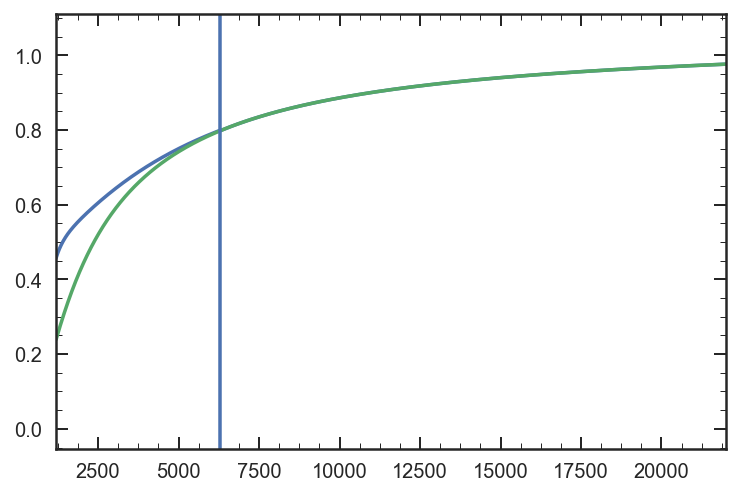

In [39]:
plt.plot(wv,dust)
plt.plot(wv,dust2)
plt.axvline(6300)
plt.xlim(1200,22000)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


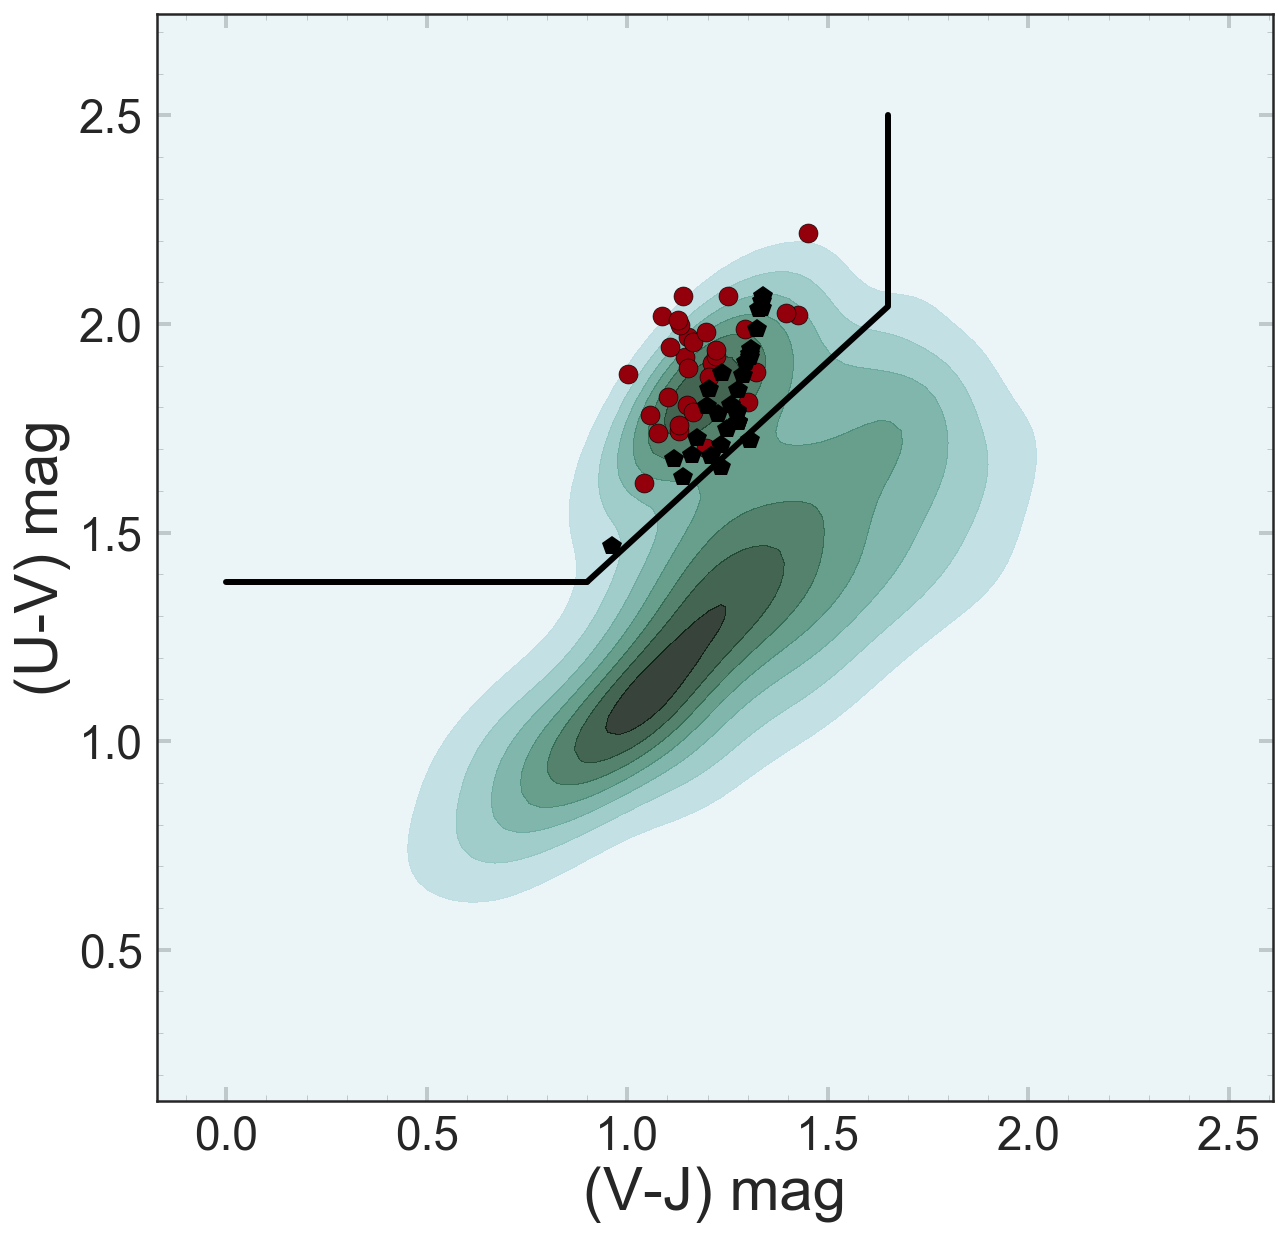

In [10]:
plt.figure(figsize=[10,10])
# sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)

# for i in range(len(uv)):
#     plt.scatter(uvjQDB['(V-J)'][uvjQDB.index[i]],uvjQDB['(U-V)'][uvjQDB.index[i]],edgecolors='k',color='#93000B',s=90)
plt.plot(vj,uv,'kp',ms=10)
#     plt.plot([uvjQDB['(V-J)'][uvjQDB.index[i]], vj[i]],[uvjQDB['(U-V)'][uvjQDB.index[i]], uv[i]],'k')

    
sea.kdeplot(uvjDB['(V-J)'],uvjDB['(U-V)'],n_levels = 7,alpha = .8,shade=True,cmap=cmap,kernel= 'epa',zorder=1)
plt.scatter(galDB.VJ,galDB.UV,edgecolors='k',color='#93000B',s=90, label = 'Selected Sample')

plt.plot([0,.9],[1.382,1.382],'k',lw=.9,linewidth=3)
plt.plot([1.65,1.65],[2.045,2.5],'k',lw=.9,linewidth=3)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9,linewidth=3)
# plt.axis([0,2.5,.5,2.5])
# plt.axis([0.5,1.7,1.3,2.2])
# plt.legend(loc=2,fontsize=25)
# plt.text(1.5,0.90,'1.0 < z < 1.8', fontsize = 30)
# plt.text(1.25,0.75,'log(M$_*$/M$_\odot$) > 10.0', fontsize = 30)
plt.xlabel('(V-J) mag',fontsize=30)
plt.ylabel('(U-V) mag',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=23,length = 7, width=2)
plt.minorticks_on()

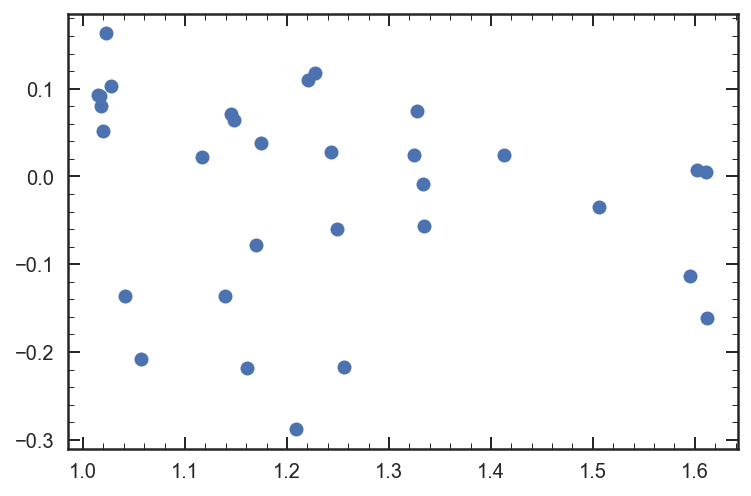

In [49]:
plt.plot(galDB.z_grism,np.log10(galDB.Zx/0.019),'o')

In [53]:
10**.1

1.2589254117941673

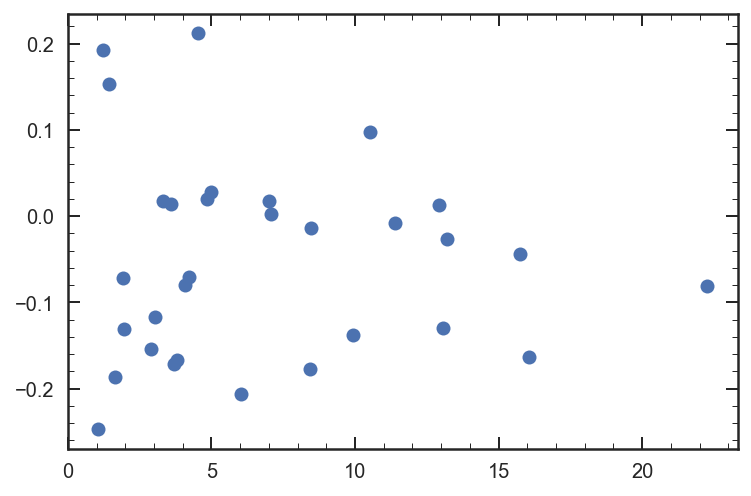

In [25]:
plt.plot(galDB.SN,uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'in'] - vj,'o')

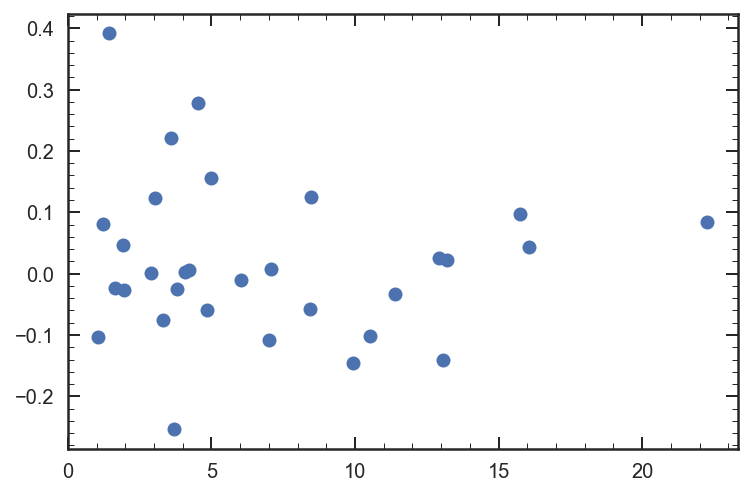

In [24]:
plt.plot(galDB.SN,uvjSDB['(U-V)'][uvjSDB.IN_SAMP == 'in'] - uv,'o')